# **EDA Project**

## **라이브러리 불러오기**

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['font.family'] ='AppleSDGothicNeoB00'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import altair as alt
from vega_datasets import data

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from pecab import PeCab
from wordcloud import WordCloud
from PIL import Image
import nltk

import os
import re
import platform

## **데이터 로드** 

In [41]:
# 데이터 로드, 확인
df = pd.read_csv('./data/fc_purchase.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159328 entries, 0 to 159327
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   거래id       159328 non-null  int64 
 1   유형         159328 non-null  object
 2   고객id       159328 non-null  int64 
 3   코스ID       159328 non-null  int64 
 4   사이트        159328 non-null  object
 5   포맷         159328 non-null  object
 6   카테고리       159328 non-null  object
 7   코스(상품) 이름  159328 non-null  object
 8   거래일자       159328 non-null  object
 9   쿠폰이름       159328 non-null  object
 10  판매가격       159328 non-null  object
 11  결제수단       159328 non-null  object
 12  실거래금액      159328 non-null  int64 
 13  쿠폰할인액      159328 non-null  object
 14  거래금액       159328 non-null  object
 15  환불금액       159328 non-null  object
dtypes: int64(4), object(12)
memory usage: 19.4+ MB


In [42]:
# 결측치 확인
df.isnull().sum()

거래id         0
유형           0
고객id         0
코스ID         0
사이트          0
포맷           0
카테고리         0
코스(상품) 이름    0
거래일자         0
쿠폰이름         0
판매가격         0
결제수단         0
실거래금액        0
쿠폰할인액        0
거래금액         0
환불금액         0
dtype: int64

## **전처리**
> 
> - 매출로 잡히지 않는 크리에이티브 카테고리 내용은 결측치로 판단 삭제.
> - 결제시간컬럼을 세부 분화 월, 요일, 시간컬럼을 추가, 넘파이 데이트타입으로 변경.
> - 특정 컬럼들의 숫자 값이 strring타입으로 되어있어 계산가능한 int타입으로 변경.
> - 실질거래건으로 보이지 않는 내부검수용은 결측지로 판단하여 제외.
> - 판매건수 및 실거래금액, 판매액 계산 시, 실 매출이 이루어지지 않는 환불 거래id들은 제외.

In [43]:
def split_string(string):
    """
    거래일자의 문자열을 분할하여 날짜와 시간 구성 요소를 추출하는 함수
        string = 분할할 문자열.
        return = 날짜, 월, 시간으로 구성된 튜플
    """
    # 공백을 기준으로 문자열 분할
    words = string.split()
    # 날짜, 시간 구성 요소 추출
    year = words[0].split('.')[0]
    month = words[1].split('.')[0]
    day = words[2].split('.')[0]
    date = f"{year}-{month}-{day}"
    time = words[3] + ' ' + words[4]
    return (date, month, time)
 

# DataFrame의 '거래일자' 열에 split_string 함수를 사용해서 date, month, time으로 분할한다.
date_df = pd.DataFrame(df['거래일자'].apply(split_string).tolist(),
                       columns=['date', 'month', 'time'])


def split_time(string):
    '''
    오전, 오후를 24시로 만들기 위해 문자열을 분할하여 시간 구성 요소를 추출하는 함수입니다.
        string = 분할할 문자열.
        int = 시간으로 구성된 정수.
    '''
    times = string.split()

    # 날짜와 시간 구성 요소 추출
    fmam = times[0].split(' ')[0]
    hours = times[1].split(':')[0]

    if fmam == '오전':
        time = int(hours)
    elif fmam == '오후':
        time = int(hours) + 12
    return (time)


date_df[['hours']] = date_df['time'].apply(split_time).apply(pd.Series)

# date의 타입을 datetime으로 변환, month를 int값으로 변환
date_df['date'] = pd.to_datetime(date_df['date'])
date_df['month'] = pd.to_numeric(date_df['month'])

# 요일 정보를 date_df에 추가
date_df['요일'] = date_df['date'].dt.day_name()

# df에 (date, month, hours, 요일) 컬럼 추가
df['date'] = date_df['date']  # 타입: datetime
df['month'] = date_df['month']  # 타입: int
df['hours'] = date_df['hours']  # 타입: int
df['요일'] = date_df['요일']  # 타입: str


# date 추가
#---------------------------------------------------------------------------------------#
def sub_columns(df, a_col, b_col):
    '''
    a_col - b_col 두 컬럼을 빼고자 하는 함수
    df = 실행하고자 하는 df
    a_col = str 으로 작성 , 1번 컬럼
    b_col = str 으로 작성 , 2번 컬럼
    pd.to_numeric(df[a_col], errors='coerce' = df,Series의 데이터 타입을 int로 변환하는 함수,
    errors='coerce'는 to_numeric의 파라미터로 int로 변환이 안되는 str같은 값을 None값으로 변환
    '''
    a_numeric = pd.to_numeric(df[a_col], errors='coerce')
    b_numeric = pd.to_numeric(df[b_col], errors='coerce')
    diff = a_numeric - b_numeric
    diff.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    df['diff'] = diff.astype(int)
    
    return df

a = sub_columns(df, '판매가격', '실거래금액')

#판매가격 - 실거래 금액이 -90000원이 넘는 값들을 b2b로 특정
a[a['diff'] < -90000]['diff']

# 실거래 금액이 -90000원이 넘는 값들 7개의 row 삭제
df_drop_b2b = df.drop([15581, 15642, 15699, 15731, 60135, 120468, 129365])

### btob를 삭제한 데이터를 사용하시려면 밑에 df -> df_drop_b2b 변경
# 환불한 값의 diff값을 삭제
# df.loc[df['유형'] == 'REFUND', 'diff'] = '-'

#b2b 작업
#---------------------------------------------------------------------------------------#

# 카테고리 크리에이티브는 검수용으로 삭제
df = df.drop(df[df['카테고리'] == '크리에이티브'].index)

# 쿠폰할인금액, 거래금액 의 숫자값이 str이라 int로 변환
df['쿠폰할인액'] = pd.to_numeric(df['쿠폰할인액'], 
                            errors='coerce').fillna(0).astype(int)
df['거래금액'] = pd.to_numeric(df['거래금액'], 
                           errors='coerce').fillna(0).astype(int)
df['판매가격'] = pd.to_numeric(df['판매가격'], 
                           errors='coerce').fillna(0).astype(int)
df['환불금액'] = pd.to_numeric(df['환불금액'], 
                           errors='coerce').fillna(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159327 entries, 0 to 159327
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   거래id       159327 non-null  int64         
 1   유형         159327 non-null  object        
 2   고객id       159327 non-null  int64         
 3   코스ID       159327 non-null  int64         
 4   사이트        159327 non-null  object        
 5   포맷         159327 non-null  object        
 6   카테고리       159327 non-null  object        
 7   코스(상품) 이름  159327 non-null  object        
 8   거래일자       159327 non-null  object        
 9   쿠폰이름       159327 non-null  object        
 10  판매가격       159327 non-null  int64         
 11  결제수단       159327 non-null  object        
 12  실거래금액      159327 non-null  int64         
 13  쿠폰할인액      159327 non-null  int64         
 14  거래금액       159327 non-null  int64         
 15  환불금액       159327 non-null  int64         
 16  date       159327 non-nul

In [44]:
# 데이터프레임으로 데이터 확인
df.head(5)

,거래id,유형,고객id,코스ID,사이트,포맷,카테고리,코스(상품) 이름,거래일자,쿠폰이름,...,결제수단,실거래금액,쿠폰할인액,거래금액,환불금액,date,month,hours,요일,diff
0,2417084,PAYMENT,20053,209016,FASTCAMPUS,올인원,업무 생산성,올인원 패키지 : 김왼손의 파이썬 업무자동화 유치원,2022. 12. 31. 오후 10:12:33,-,...,TRANSFER,159000,0,159000,0,2022-12-31,12,22,Saturday,30000
1,2415408,PAYMENT,58309,210664,FASTCAMPUS,올인원,부동산/금융,초격차 패키지 : 한 번에 끝내는 부동산 금융(PF) 실무,2022. 12. 30. 오후 6:12:57,-,...,TRANSFER,501000,0,501000,0,2022-12-30,12,18,Friday,0
2,2413897,PAYMENT,18075,211782,FASTCAMPUS,올인원,영상/3D,편집하는여자의 영상편집 마스터클래스 - 제 6강 다양한 효과를 응용하여 애프터이펙트...,2022. 12. 31. 오후 11:12:15,-,...,CARD,549000,0,549000,0,2022-12-31,12,23,Saturday,0
3,2413891,PAYMENT,41898,213450,FASTCAMPUS,올인원,프로그래밍,초격차 패키지 : 35개 프로젝트로 배우는 Android 앱 개발 feat. Jet...,2022. 12. 31. 오후 11:12:03,[WELCOME] 프로그래밍 3만원할인,...,CARD,135000,30000,135000,0,2022-12-31,12,23,Saturday,30000
4,2413887,PAYMENT,94328,210773,FASTCAMPUS,올인원,프로그래밍,"초격차 패키지 : 개발자 취업 합격 패스 With 코딩테스트, 기술면접",2022. 12. 31. 오후 11:12:10,-,...,CARD,239000,0,239000,0,2022-12-31,12,23,Saturday,0


In [45]:
df.tail(5)

,거래id,유형,고객id,코스ID,사이트,포맷,카테고리,코스(상품) 이름,거래일자,쿠폰이름,...,결제수단,실거래금액,쿠폰할인액,거래금액,환불금액,date,month,hours,요일,diff
159323,1551424,PAYMENT,39658,204491,FASTCAMPUS,올인원,부업/창업,올인원 패키지 : 제 2의 월급을 만들어주는 직장인 스몰비즈니스 가이드,2022. 1. 1. 오전 12:01:08,[NEW22] 온라인 강의 1만원 즉시 추가 할인 쿠폰,...,CARD,207000,10000,207000,0,2022-01-01,1,12,Saturday,10000
159324,1551410,PAYMENT,95136,206811,FASTCAMPUS,올인원,영상/3D,[Kit] 닷밀의 미디어아트 그래픽 클래스 : 모션그래픽 뉴패러다임 Creative...,2022. 1. 1. 오전 12:01:12,-,...,CARD,385000,0,385000,0,2022-01-01,1,12,Saturday,0
159325,1551361,PAYMENT,12764,202927,FASTCAMPUS,올인원,데이터 사이언스,올인원 패키지 : 파이썬을 활용한 데이터 전처리 Level UP,2022. 1. 1. 오전 12:01:21,[WELCOME] 패캠은 처음이지? 3만원 할인쿠폰,...,CARD,136000,30000,136000,0,2022-01-01,1,12,Saturday,30000
159326,1545070,PAYMENT,19606,208104,FASTCAMPUS,올인원,업무 생산성,올인원 패키지 : 100억을 움직이는 50가지 PPT 디자인 원칙,2022. 1. 2. 오전 11:01:24,-,...,VBANK,289000,0,289000,0,2022-01-02,1,11,Sunday,0
159327,1486194,REFUND,62567,207488,FASTCAMPUS,올인원,데이터 사이언스,올인원 패키지 : 머신러닝 서비스 구축을 위한 실전 MLOps,2022. 1. 24. 오전 4:01:00,-,...,TRANSFER,-345240,0,0,-345240,2022-01-24,1,4,Monday,715240



---
## 1. **분석 및 데이터 시각화**

### **Factor: 고객**
> 실거래금액으로 매출, 결제건, 쿠폰분석을 통해, 주 고객군을 분석 \
> B2C, B2B, 학생, 직장인, 기업, 신규or기존고객 인지 어떤고객이 주 고객인지? \
> 주 고객군이 확인되면 마케팅에서 Audience설정전략을 수립할 수 있지 않을까? 


#### 01. **구매횟수별 고객수 분포**

In [46]:
# payment 고객만 걸러내는 dataset 만들기
paid_df = df[df['유형']=='PAYMENT']

# 각 고객id의 총 결제 회수 확인하기
grouped_data = paid_df.groupby('고객id').agg({
    '코스ID': 'nunique',
    '실거래금액' : 'sum'}
    )
grouped_data = grouped_data.reset_index()
grouped_data = grouped_data.rename(columns={'코스ID':'수강 회수'})

# 각 수강회수별 실거래금액 확인
couse_cnt = grouped_data.groupby('수강 회수').agg({
    '고객id': 'nunique',
    '실거래금액' : 'sum'})
couse_cnt = couse_cnt.rename(columns={'고객id':'수강한 고객 수'})
couse_cnt['실거래금액'] = couse_cnt['실거래금액']/10000000
couse_cnt = couse_cnt.reset_index()

# bar chart
bar_graph = alt.Chart(couse_cnt).mark_bar().encode(
    x = alt.X('수강 회수:N',sort=alt.EncodingSortField(field='수강 회수:N')),
    y = alt.Y('수강한 고객 수:Q', 
            stack=None, 
            title='수강한 고객 수(명)', 
            axis=alt.Axis(title='수강한 고객 수(명)')),
    color = alt.Color('수강 회수:N')
    )

# line chart
line_graph = alt.Chart(couse_cnt).mark_line().encode(
    x = alt.X('수강 회수:N',
              sort=alt.EncodingSortField(field='수강 회수')),
    y = alt.Y('실거래금액:Q', 
              axis=alt.Axis(title='실거래금액(억)')),
    color = alt.value("red")
    )

line_graph_text = line_graph.mark_text(
    align='left',
    baseline='middle',
    dx=3, # x축에서 텍스트의 위치를 조정
    dy=-3, # y축에서 텍스트의 위치를 조정
    color='red'
).encode(
    text=alt.Text('실거래금액:Q', format=',.0f') # 표시할 값 및 숫자 포맷을 지정
)

combi_graph = alt.layer(
    bar_graph,
    line_graph,
    line_graph_text # 추가한 line 그래프 텍스트를 레이어에 추가
).resolve_scale(
     y='independent'
)

combi_graph

alt.LayerChart(...)

In [47]:
# 데이터 준비
couse_cnt = couse_cnt.sort_values(by='수강 회수')

# 서브플롯 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 막대 그래프 추가
fig.add_trace(go.Bar(x=couse_cnt['수강 회수'], 
                     y=couse_cnt['수강한 고객 수'], 
                     name='수강한 고객 수'), 
              secondary_y=False)

# 선 그래프 추가
fig.add_trace(go.Scatter(x=couse_cnt['수강 회수'], 
                         y=couse_cnt['실거래금액'], 
                         mode='lines+markers', 
                         name='실거래금액', 
                         line=dict(color='red')), 
              secondary_y=True)

# 축 타이틀 설정
fig.update_layout(title='수강 회수별 고객 수 및 실거래금액', 
                  xaxis_title='수강 회수', 
                  yaxis_title='수강한 고객 수(명)', 
                  yaxis2_title='실거래금액(억)',
                  font=dict(
                      family="AppleSDGothicNeoB00",
                      size=13,
                      color="black")
                      )
# 그래프 출력
fig.show()

#### 02. **2회 이상 구매자 카테고리 연속성**

In [48]:
df_PAYMENT = df[df['유형'] == "PAYMENT"]

# 구매를 한 데이터중 고객id를 그룹화 하고 date를 sort하여 고객id별 첫번째 인댁스값을 추출한다.

# first_payment_df는 고객이 처음으로 구매한 구매 내역이다.
first_payment_df = df_PAYMENT.sort_values('date').groupby('고객id').nth(0).reset_index()
# 첫 구매를 어떤 상품을 했는지 알아보기위해 상품이름이 많은 순으로 15개의 데이터를 추출한다.
first_payment_df_count = first_payment_df['코스(상품) 이름'].value_counts().head(15).to_frame()

# 2번 이상 구매한 사람들은 어떤 강의를 결제를 하였는지 추출한다.
second_payment_df = df_PAYMENT.sort_values('date').groupby('고객id').nth(1).reset_index()
second_payment_df_count = second_payment_df['코스(상품) 이름'].value_counts().head(15).to_frame()

# 3번 이상 구매한 사람들은 어떤 강의를 결제를 하였는지 추출한다.
third_payment_df = df_PAYMENT.sort_values('date').groupby('고객id').nth(2).reset_index()
third_payment_df_count = third_payment_df['코스(상품) 이름'].value_counts().head(15).to_frame()

In [49]:
# 3개의 데이터를 확인했을때 연속성이 보지이 않는것 같아 3번 이상 구매한 사람들의 데이터를 보았을때 강의의 연속성을 지니지 않는다

df_PAYMENT[df_PAYMENT['고객id'] == 85571]

,거래id,유형,고객id,코스ID,사이트,포맷,카테고리,코스(상품) 이름,거래일자,쿠폰이름,...,결제수단,실거래금액,쿠폰할인액,거래금액,환불금액,date,month,hours,요일,diff
590,2411787,PAYMENT,85571,203499,FASTCAMPUS,올인원,업무 생산성,올인원 패키지 : 100억을 움직이는 단 10장의 PPT,2022. 12. 31. 오후 5:12:50,-,...,TRANS,173000,0,173000,0,2022-12-31,12,17,Saturday,0
42566,2178403,PAYMENT,85571,206257,FASTCAMPUS,올인원,프로그래밍,초격차 패키지 : 게임 개발자 취업의 모든 것,2022. 9. 30. 오후 3:09:37,-,...,TRANSFER,294000,0,294000,0,2022-09-30,9,15,Friday,0
126680,1703173,PAYMENT,85571,202785,FASTCAMPUS,올인원,마케팅,올인원 패키지 : 인스타를 성장시킨 50명의 성공방정식,2022. 3. 1. 오후 2:03:07,[프로모션] 2월 1+1 수강권 이벤트,...,PROMOTION,0,123000,0,0,2022-03-01,3,14,Tuesday,103000


In [50]:
# 타 사이트와 비교. > 타 사이트는 다음 강의를 어떤걸 들으면 좋은지에 대한 가이드 라인이 있다
# 그렇다면 연속성을 갖고 있는 사람은 얼마나 되는지 확인을 해보자

# 첫 구매한 내역과 두번째 구매한 내역의 고객id, 카테고리가 같은것들만 inner join을 하여 몇개가 있는지 확인한다.
merged12_df = first_payment_df.merge(second_payment_df, 
                                     on=['고객id', '카테고리'], 
                                     how='inner')
len(merged12_df)
# 첫 구매한 내역과 세번째 구매한 내역도 확인을 한다.
merged13_df = third_payment_df.merge(first_payment_df, 
                                     on=['고객id', '카테고리'], 
                                     how='inner')
len(merged13_df)
# 첫 구매한 내역부터 세번째 구매한 내역의 고객id와 카테고리가 같은 내역을 확인을 한다.
merged123_df = merged12_df.merge(third_payment_df, 
                                 on=['고객id', '카테고리'], 
                                 how='inner')
len(merged123_df)

# merged12_df 와 merged13_df 의 합은 어느정도 연속성이 있는 구매자라고 판단한다.
# merged13_df는 merged12_df와 merged13_df 두 데이터에 겹쳐지므로 (-)를 한다.
continuity = len(merged12_df) + len(merged13_df) - len(merged123_df)

In [51]:
# 한번만 구매한 사람은 연속성에 포함이 안되므로 전체 구매자에서 빼준기 위해 한번만 구매한 사람들의 수를 구한다.
group_df = df_PAYMENT.groupby('고객id').agg({'코스ID': 'nunique'})
group_df_cid = group_df.groupby('코스ID').value_counts()

In [52]:
# 전체 구매자에서 한번만 구매한 사람을 빼준다. -> 2번이상 구매한 사람들
multiple_payments = len(df_PAYMENT['고객id'].unique()) - group_df_cid[1]
multiple_payments

43350

In [53]:
len(merged12_df)
len(merged123_df)
len(merged13_df)
continuity_data = {'2회 이상 구매고객': [multiple_payments], 
                   '1-2 연속고객': [len(merged12_df)], 
                   '1-2-3 연속고객': [len(merged123_df)], 
                   '1-3 연속고객': [len(merged13_df)]
                   }

continuity_df = pd.DataFrame(continuity_data)
continuity_df 

,2회 이상 구매고객,1-2 연속고객,1-2-3 연속고객,1-3 연속고객
0,43350,7363,709,3137


In [54]:
# 2번이상 구매한 사람들중 연속성을 지니고 있는 사람들은 22.59% 이다.
continuity_per = round(((continuity / multiple_payments) * 100), 2)
print(continuity_per)
# 2번이상 구매한 사람들중 연속성을 지니고 있는 사람들은 22.59% 이다.
# 데이터 준비
labels = ['Continuity', 'Non-continuity']
values = [continuity_per, 100 - continuity_per]

# 시각화
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# 제목 추가
fig.update_layout(title_text="Percentage of Customers with Continuity",
                  font=dict(
                      family="AppleSDGothicNeoB00",
                      size=13,
                      color="black"))

# 그래프 출력
fig.show()

22.59


In [55]:
# 데이터 준비
continue_df = pd.DataFrame({
    'Category': ['Continuity', 'Non-continuity'],
    'Percentage': [continuity_per, 100 - continuity_per]
})

# 시각화
chart = alt.Chart(continue_df).mark_bar().encode(
    x='Category',
    y='Percentage'
)

# 제목 추가
chart = chart.properties(title='Percentage of Customers with Continuity')

# 그래프 출력
chart

alt.Chart(...)

#### 03. **고객 결제수단**

In [56]:
# 전체 고객의 payment 방식
all_pay = paid_df[['결제수단']]
all_pay = pd.DataFrame(all_pay.groupby('결제수단').value_counts())
all_pay = all_pay.reset_index().sort_values('count')

base = alt.Chart(all_pay).encode(
    alt.Theta("count:Q").stack(True),
    alt.Radius("count").scale(type="sqrt", zero=True, rangeMin=20),
    color="결제수단:N", 
    order="count")

c1 = base.mark_arc(innerRadius=25, stroke="#fff")
c2 = base.mark_text(radiusOffset=20).encode(text="count:N")
c1 + c2

alt.LayerChart(...)

In [57]:
# 데이터 준비
all_pay = paid_df['결제수단'].value_counts().reset_index()
all_pay.columns = ['결제수단', 'count']

# 시각화
fig = px.pie(all_pay, values='count', names='결제수단')

# 폰트 설정
fig.update_layout(
    font=dict(
        family="AppleSDGothicNeoB00",
        size=13,
        color="black"
    )
)

# 그래프 출력
fig.show()

##
---
### - Factor : 상품(코스) & 상품군(카테고리)
    매출 및 결제건을 통한 주력 카테고리 및 상품을 확인한다.
    상품명 분석을 통해 패키지, 프리미엄, 단일코스 중 무엇이 매출에 주요 요소인지.


#### 04. **카테고리별 매출 그 비중 및 결제 횟수**

In [58]:
df_paid = df[df["유형"].str.contains("PAYMENT")] # 환불 제외, 결제한 데이터만 생성

# 카테고리별 실거래금액(매출액) 합계 
category_group_sum = df_paid.groupby("카테고리")["실거래금액"].sum().reset_index().sort_values(by="실거래금액", 
                                                                                      ascending=False)

# 그래프에 표시할 카데고리 순서
category_order = ['프로그래밍', 
                  '데이터 사이언스', 
                  '일러스트', 
                  '부동산/금융', 
                  '영상/3D', 
                  '마케팅', 
                  '업무 생산성', 
                  '디자인', 
                  '투자/재테크', 
                  '부업/창업']

# 실거래금액 비율 계산
category_group_sum_rate = category_group_sum.copy()
total_sum = category_group_sum_rate['실거래금액'].sum()
category_group_sum_rate['실거래금액 비율'] = np.round(category_group_sum_rate['실거래금액']/total_sum*100, 
                                               decimals=1)

base = alt.Chart(category_group_sum_rate).encode(alt.Theta("실거래금액:Q", 
                                                           title="실거래금액 비율").stack(True),
                                                 alt.Radius("실거래금액").scale(type="sqrt", 
                                                                           zero=True, 
                                                                           rangeMin=20),
                                                 color=alt.Color("카테고리:N", 
                                                                 scale=alt.Scale(scheme='category20'), 
                                                                 sort=category_order))

c1 = base.mark_arc(innerRadius=25, stroke="#fff")
c2 = base.mark_text(radiusOffset=0).encode(text="실거래금액 비율:N",
                                           color=alt.value("black"), 
                                           order=alt.Order("카테고리:N"))
c3 = base.mark_text(radiusOffset=25).encode(text="카테고리:N", 
                                            order=alt.Order("카테고리:N"))

chart = alt.layer(c1, c2, c3).configure_legend(orient='right').properties(title="카테고리별 매출액 비율(%)")
chart

alt.LayerChart(...)

In [59]:
# 총 판매된 강의의 카테고리와 실거래금액 분석해 보겠습니다.
sales_df = pd.DataFrame(paid_df.groupby('카테고리')['실거래금액'].sum())
sales_df['판매 건 수'] = paid_df.value_counts('카테고리')

sales_df = sales_df.reset_index()

sales_df = sales_df.sort_values('판매 건 수', ascending = False)
sales_data = sales_df  #.drop(8)

# bar chart
bar_chart = alt.Chart(sales_data).mark_bar().encode(x=alt.X('카테고리:N',
                                                            sort=alt.EncodingSortField(field='실거래금액')),
                                                    y=alt.Y('실거래금액:Q', 
                                                            stack=None, 
                                                            title='실거래금액', 
                                                            axis=alt.Axis(title='실거래금액')),
                                                    )

# line chart
line_chart = alt.Chart(sales_data).mark_line(color='red').encode(x=alt.X('카테고리:N',
                                                                         sort=alt.EncodingSortField(field='실거래금액')),
                                                                 y=alt.Y('판매 건 수:Q', 
                                                                         axis=alt.Axis(title='판매 건 수')),
                                                                 )

# combine charts
combined_chart = alt.layer(bar_chart, line_chart,).resolve_scale(y='independent')

combined_chart

alt.LayerChart(...)

In [60]:
# 데이터 준비
# 총 판매된 강의의 카테고리와 실거래금액 분석해 보겠습니다.
sales_df = pd.DataFrame(paid_df.groupby('카테고리')['실거래금액'].sum())
sales_df['판매 건 수'] = paid_df.value_counts('카테고리')

sales_df = sales_df.reset_index()

sales_df = sales_df.sort_values('판매 건 수', ascending = False)
sales_data = sales_df  #.drop(8)

# 서브플롯 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 막대 그래프 추가
fig.add_trace(go.Bar(x=sales_data['카테고리'], 
                     y=sales_data['실거래금액'], 
                     name='실거래금액'), 
              secondary_y=False)

# 선 그래프 추가
fig.add_trace(go.Scatter(x=sales_data['카테고리'], 
                         y=sales_data['판매 건 수'], 
                         mode='lines', 
                         name='판매 건 수', 
                         line=dict(color='red')), 
              secondary_y=True)

# 축 타이틀 설정
fig.update_layout(title_text='카테고리별 실거래금액 및 판매 건 수',
                  xaxis_title='카테고리',
                  yaxis_title='실거래금액',
                  yaxis2_title='판매 건 수',
                  font=dict(
                      family="AppleSDGothicNeoB00",
                      size=13,
                      color="black"))

# 그래프 출력
fig.show()

#### 05. **카테고리별 쿠폰할인 비율 및 금액 비교** (그래프 합치기)

In [61]:
# 전체 상품 카테고리 별 나누기 위한 코드
# 필터링 적용: '크리에이티브' 카테고리와 'REFUND' 유형을 제외한 데이터만 가져오기
category_filtered_df = df[df['유형']!='REFUND']

# 데이터 집계: 카테고리별로 판매가격 합계, 쿠폰 할인액 합계, 거래 건수를 집계
total_category_grouped = \
    category_filtered_df.groupby('카테고리').agg({'판매가격': 'sum', 
                                              '쿠폰할인액': 'sum', 
                                              '거래id': 'count'}).reset_index()
# 집계된 데이터프레임의 열 이름 변경
total_category_grouped.columns = ['카테고리',
                                  '판매가격', 
                                  '쿠폰할인액', 
                                  'count']

# total_category_grouped 데이터프레임에 할인율 컬럼을 추가: 쿠폰할인액 / 판매가격 * 100
total_category_grouped['할인율'] = \
    (total_category_grouped['쿠폰할인액'] / total_category_grouped['판매가격']) * 100

# 쿠폰 사용된 행만 필터링: 쿠폰이름이 결측치가 아니고 '-'가 아닌 행만 선택
category_filtered_df_with_coupons = \
    category_filtered_df[category_filtered_df['쿠폰이름'].notnull()  & (df['쿠폰이름'] != '-')]

# 쿠폰 사용 개수 집계: 카테고리별로 쿠폰이름의 건수를 집계
category_coupon_count = category_filtered_df_with_coupons.groupby('카테고리')['쿠폰이름'].count().reset_index()
# 집계된 데이터프레임의 열 이름 변경
category_coupon_count.columns = ['카테고리', '쿠폰사용개수']

# total_category_grouped에 쿠폰 사용 개수 추가: '카테고리' 열을 기준으로 category_coupon_count를 병합
total_category_grouped = total_category_grouped.merge(category_coupon_count, 
                                                      on='카테고리', 
                                                      how='left')

# 판매가격 기준으로 내림차순 정렬
total_sorted_category_grouped = total_category_grouped.sort_values(by='판매가격', 
                                                                   ascending=False)


In [63]:
# 데이터 준비
total_sorted_category_grouped = total_sorted_category_grouped.reset_index()

# 서브플롯 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 막대 그래프 추가
fig.add_trace(go.Bar(x=total_sorted_category_grouped['카테고리'], 
                     y=total_sorted_category_grouped['판매가격'], 
                     name='판매금액', 
                     offset=-0.2, 
                     width=0.4), 
              secondary_y=False)

fig.add_trace(go.Bar(x=total_sorted_category_grouped['카테고리'], 
                     y=total_sorted_category_grouped['쿠폰할인액'], 
                     name='할인액', 
                     offset=0.2, 
                     width=0.4), 
              secondary_y=False)

# 선 그래프 추가
fig.add_trace(go.Scatter(x=total_sorted_category_grouped['카테고리'], 
                         y=total_sorted_category_grouped['count'], 
                         mode='lines+markers+text', 
                         name='판매건수', 
                         line=dict(color='red'), 
                         text=total_sorted_category_grouped['count'], 
                         textposition='top center'), 
              secondary_y=True)

fig.add_trace(go.Scatter(x=total_sorted_category_grouped['카테고리'], 
                         y=total_sorted_category_grouped['쿠폰사용개수'], 
                         mode='lines+markers+text', 
                         name='쿠폰사용개수', 
                         line=dict(color='green'), 
                         text=total_sorted_category_grouped['쿠폰사용개수'], 
                         textposition='bottom center'), 
              secondary_y=True)

# 축 타이틀 설정
fig.update_layout(title_text='전체 상품의 각 카테고리별 판매금액, 할인액 및 거래 횟수',
                  xaxis_title='카테고리',
                  yaxis_title='판매금액 (만 원 단위)',
                  yaxis2_title='판매 건 수 / 쿠폰사용개수',
                  font=dict(
                      family="AppleSDGothicNeoB00",
                      size=13,
                      color="black"))

# 그래프 출력
fig.show()


In [64]:
# payment 고객만 걸러내는 dataset 만들기
paid_df = df[df['유형']=='PAYMENT']

# 총 판매된 강의의 카테고리와 판매가격, 쿠폰할인액을 분석해 보겠습니다.
categ_df = paid_df.groupby('카테고리')[['판매가격','쿠폰할인액']].sum()
categ_df['판매 건 수'] = paid_df.value_counts('카테고리')
all_cat = categ_df.sort_values('판매가격', ascending = False).reset_index()
# all_cat = all_cat.drop(10)

# 시각화를 위해 데이터프레임을 조작하겠습니다(1)
Frame_cat = all_cat.drop(['판매가격','쿠폰할인액','판매 건 수'],axis=1)

# 판매가격만 나타나는 데이터프레임
Frame_cat['유형'] = '판매가격'
Frame_cat['금액'] = all_cat['판매가격']
Frame_cat['판매 건 수'] = all_cat['판매 건 수']

frame_cat = all_cat  #.drop(['판매가격','쿠폰할인액','판매 건 수'],axis=1)

# 쿠폰할인액만 나타나는 데이터프레임
frame_cat['유형'] = '쿠폰할인액'
frame_cat['금액'] = all_cat['쿠폰할인액']
frame_cat['판매 건 수'] = all_cat['판매 건 수']

# 두 데이터를 합칩니다.
cat_merged = pd.concat([Frame_cat,frame_cat], axis=0)
cat_merged = cat_merged.sort_values(by=['유형','금액'], ascending = False)
cat_merged['y_label'] = '판매 건 수'

bar_chart = alt.Chart(cat_merged).mark_bar(opacity=0.7).encode(x=alt.X('카테고리:N',
                                                                       sort=alt.EncodingSortField(field='판매 건 수')),
                                                               y=alt.Y('금액:Q', 
                                                                       stack=None, 
                                                                       title='금액'),
                                                               color=alt.Color('유형:N')
                                                               )
bar_chart

alt.Chart(...)

In [65]:
N_bar_chart = alt.Chart(cat_merged).mark_bar(opacity=0.7).encode(x=alt.X('카테고리:N',
                                                                         sort=alt.EncodingSortField(field='금액')),
                                                                 y=alt.Y('금액:Q', 
                                                                         stack='normalize',
                                                                         title='금액'),
                                                                 color=alt.Color('유형:N')
                                                                 )
N_bar_chart

alt.Chart(...)

### 06. 연간 카테고리별 매출 비율 변화

In [66]:
pay_df = df[df['유형']=='PAYMENT'][['카테고리', '실거래금액','month']]
gr_pay = pd.DataFrame(pay_df.groupby(['카테고리','month'])['실거래금액'].sum())
cat_df = gr_pay.reset_index()
cat_df = cat_df.sort_values('실거래금액')

# 시각화
total_amount_by_category = cat_df.groupby('카테고리')['실거래금액'].sum().reset_index()
total_amount_by_category.columns = ['카테고리', '총 실거래금액']
cat_df = cat_df.merge(total_amount_by_category, on='카테고리')

# 시각화
alt.Chart(cat_df).mark_area().encode(x="month:N",
                                     y=alt.Y("실거래금액:Q", stack="normalize"),
                                     color=alt.Color("카테고리:N",legend=alt.Legend(title='카테고리')).sort(['프로그래밍',
                                                                                                     '데이터 사이언스',
                                                                                                     '일러스트', 
                                                                                                     '부동산/금융', 
                                                                                                     '영상/3D', 
                                                                                                     '마케팅', 
                                                                                                     '업무 생산성', 
                                                                                                     '디자인', 
                                                                                                     '투자/재테크', 
                                                                                                     '부업/창업']),
                                     order=alt.Order('총 실거래금액:Q', sort='descending')
                                     )

alt.Chart(...)

#### 07. **상품 키워드 빈도** (일러스트 카테고리 6~12월 상품 키워드로 변경)

In [67]:
# 키워드 분석을 위한 text_cleaning, text_tokenizing 설정과 불용어 지정
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc) # 한글과 빈칸 빼고 지우고 공백으로 처리,'^':제외
    return doc

def define_stopwords(path):
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    SW.add("대한")
    SW.add("합니다")
    SW.add("하는")
    SW.add("초격차")
    SW.add("패키지")
    SW.add("올인원")
    SW.add("끝내는")
    SW.add("번에")
    SW.add("배우는")
    SW.add("위한")
    SW.add("활용한")
    SW.add("모든")
    SW.add("만드는")
    SW.add("한번에")
    SW.add("일러스트")
  
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
    return SW

def text_tokenizing(doc, tokenizer):
    tok = PeCab() # 형태소 분석기 선언. (객체 선언)
    
    if tokenizer == "words":
        return [word for word in doc.split() if word not in SW and len(word) > 1]
    
    elif tokenizer == "nouns":
        return [token for token in tok.nouns(doc) if token not in SW and len(token) > 1]
        
    elif tokenizer == "morphs":
        return [token for token in tok.morphs(doc) if token not in SW and len(token) > 1]
    
    elif tokenizer == "predefined": # 내 마음대로
        
        documents = []
        text_pos = [pair for pair in tok.pos(doc) if pair[0] not in SW and len(pair[0]) >= 1]
        words = []

        for word, pos in text_pos:
            if pos in FEATURE_POS:
                words.append(word)
        return words

In [68]:
# 불용어 지정하여 필요없는 토큰을 제거 token filtering.
SW = define_stopwords("data/stopwords-ko.txt")
tokenizer = "words" # "words" / "nouns" / "morphs" / "predefined"

# 5월~10월 일러스트 카테고리의 수강 강의 데이터 프레임 뽑기
documents_ilust5 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 5)]["코스(상품) 이름"]
documents_ilust6 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 6)]["코스(상품) 이름"]
documents_ilust7 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 7)]["코스(상품) 이름"]
documents_ilust8 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 8)]["코스(상품) 이름"]
documents_ilust9 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 9)]["코스(상품) 이름"]
documents_ilust10 = df_paid[(df_paid["카테고리"]=="일러스트") & (df_paid["month"] == 10)]["코스(상품) 이름"]

# 각각의 데이터 프레임을 넣어 tokenized_documents 정의
tokenized_documents = documents_ilust10.apply(text_cleaning).apply(text_tokenizing, tokenizer = tokenizer)
# 가장 많이 나오는 단어 3개 확인
total_tokens = []
for doc in tokenized_documents: # 첫 줄 리스트
    for token in doc: # 단어로 짤린것, tokenized 된 것
        total_tokens.append(token)
    
print(len(total_tokens))

text = nltk.Text(total_tokens)
print(len(set(text.tokens)))

text.vocab().most_common(3) # 가장 많이 나오는 단어 3개 확인

# 단어 빈도수가 높은 순으로 30개를 뽑아 word cloud이미지 만들기
topN = 30
x = []
y = []
wordInfo = dict()

for vocab, count in text.vocab().most_common(topN):
    x.append(vocab)
    y.append(count)
    wordInfo[vocab] = count

mask = np.array(Image.open("data/cloud.png"))
wordcloud = WordCloud(font_path = "AppleGothic",
                      relative_scaling = 0.2,
                      mask=mask,
                      background_color='white',
                      colormap="twilight"
                      ).generate_from_frequencies(wordInfo)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

8744
117


OSError: cannot open resource

#### 08. **The RED 코스** (환불율, 강의 당 매출, 올인원vs레드 매출비교)

findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: 

Text(0.5, 1.0, "'올인원' 대비 'The RED'의 매출비율")

findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: 

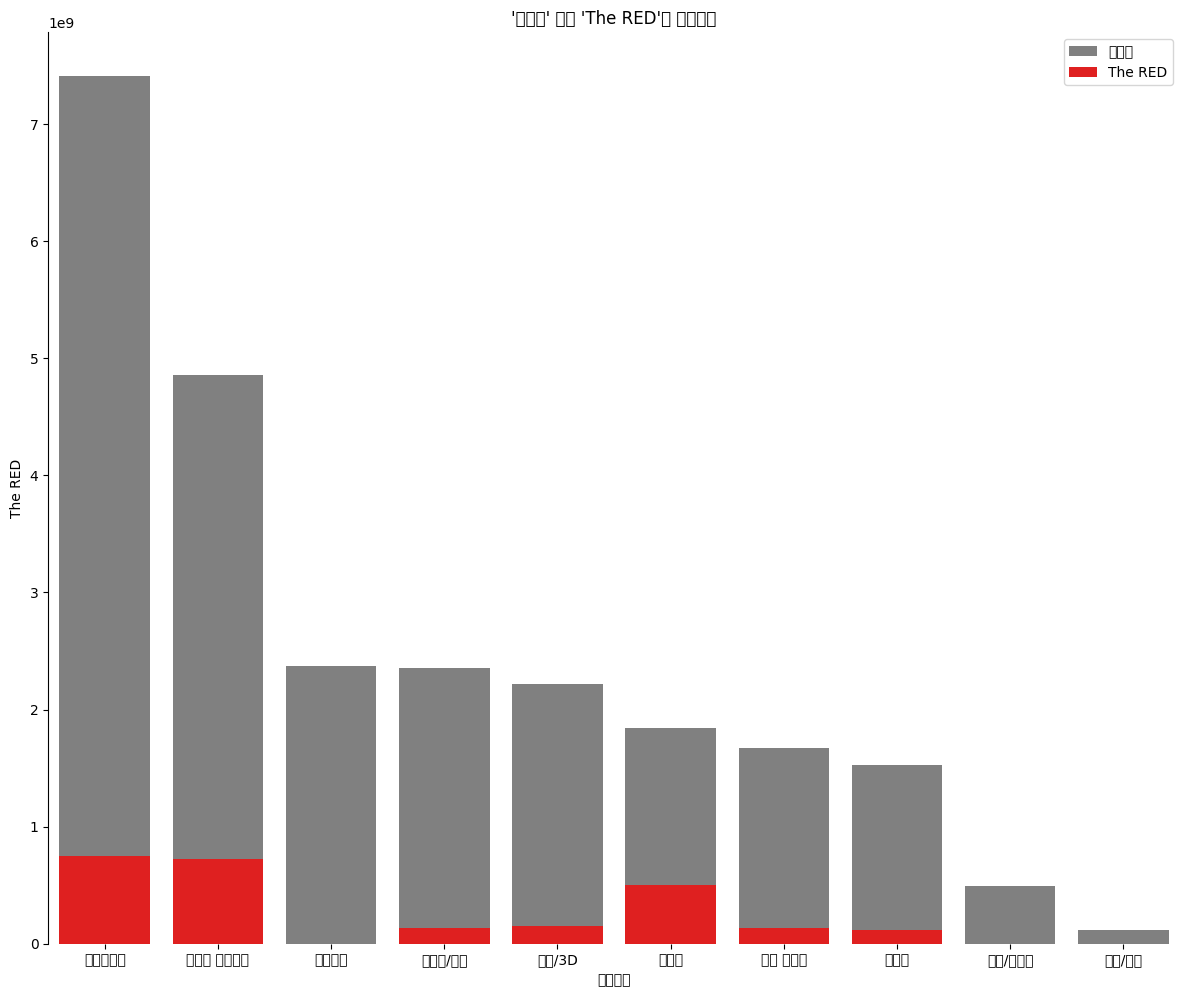

In [71]:
df_paid = df[df["유형"].str.contains("PAYMENT")]

# 카테고리별 실거래금액 합계
category_group_sum = df_paid.groupby("카테고리")["실거래금액"].sum().reset_index().sort_values(by="실거래금액", 
                                                                                      ascending=False)

# 카테고리별 'The RED' 실거래금액 합계 category_groupTheRED_sum
category_groupTheRED_sum = df_paid[df_paid["포맷"]=="RED"].groupby("카테고리")["실거래금액"].sum().to_frame().reset_index()

# '올인원' 대비 'The RED'의 매출비율 그래프 그리기
fig, ax= plt.subplots(nrows=1, 
                      ncols=1, 
                      figsize=(12, 10), 
                      sharex=True)
order=['프로그래밍', '데이터 사이언스', '일러스트', '부동산/금융','일러스트', '영상/3D', '마케팅', '업무 생산성', '디자인', '투자/재테크', '부업/창업']

# 레이블을 지정하여 barplot 생성
bar1 = sns.barplot(data=category_group_sum, y="실거래금액", x="카테고리", color="grey", order=order, label="올인원")
bar2 = sns.barplot(data=category_groupTheRED_sum, y="실거래금액", x="카테고리", color="red", order=order, label="The RED")

sns.barplot(data=category_group_sum, y="실거래금액", x="카테고리", color="grey", order=order)

# ax_01.axhline(0, color="k", clip_on=False)

ax.set_ylabel("올인원")
sns.barplot(data=category_groupTheRED_sum, y="실거래금액", x="카테고리", color="red", order=order)

# 범례 추가
ax.legend()

# ax_02.axhline(0, color="k", clip_on=False)
ax.set_ylabel("The RED")
sns.despine(bottom=True)
# plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.title("'올인원' 대비 'The RED'의 매출비율") 

In [72]:
# The red df
# '포맷' 컬럼에 'RED' 문자열이 포함된 데이터프레임 생성
red_df = df[df['포맷'] == 'RED']

# 'RED' 포맷에서 'REFUND' 유형의 거래 수 계산
red_refund_count = len(red_df[red_df['유형'] == 'REFUND'])

# 전체 거래 수 계산
red_total_transactions = len(red_df)

# 환불율 계산
red_refund_rate = (red_refund_count / red_total_transactions) * 100

# 결과 출력
print(f"RED 포맷의 전체 환불율(건수 기준): {red_refund_rate:.2f}%")

# 'RED' 포맷의 카테고리별 환불율, 환불개수 및 수강개수 계산
red_categories = red_df['카테고리'].unique()
red_refund_rates = []
red_refund_counts = []
red_course_counts = []

for category in red_categories:
    category_df = red_df[red_df['카테고리'] == category]
    red_refund_count = len(category_df[category_df['유형'] == 'REFUND'])
    red_total_transactions = len(category_df)
    refund_rate = (red_refund_count / red_total_transactions) * 100
    red_refund_rates.append(refund_rate)
    red_refund_counts.append(red_refund_count)
    red_course_counts.append(red_total_transactions)

# 환불율, 환불개수 및 수강개수 데이터프레임 생성
red_refund_rate_df = pd.DataFrame({'카테고리': red_categories, 
                                   '환불율(건수 기준)': red_refund_rates, 
                                   '환불개수': red_refund_counts, 
                                   '수강개수': red_course_counts
                                   })

# 환불율 컬럼의 값을 소숫점 둘째 자리에서 반올림
red_refund_rate_df['환불율(건수 기준)'] = red_refund_rate_df['환불율(건수 기준)'].round(2)

# 데이터프레임 출력: '환불율(건수 기준)'을 기준으로 내림차순 정렬
red_refund_rate_df = red_refund_rate_df.sort_values(by= '환불율(건수 기준)', 
                                                    ascending = False)
red_refund_rate_df


RED 포맷의 전체 환불율(건수 기준): 7.80%


,카테고리,환불율(건수 기준),환불개수,수강개수
3,디자인,11.34,60,529
1,영상/3D,10.85,65,599
6,데이터 사이언스,10.24,263,2569
4,업무 생산성,9.52,73,767
2,마케팅,6.91,220,3185
0,프로그래밍,6.18,244,3950
5,부동산/금융,5.17,41,793


In [73]:
# '올인원' 포맷의 데이터프레임 생성
all_in_one_df = df[df['포맷'] == '올인원']

# '올인원' 포맷에서 'REFUND' 유형의 거래 수 계산
all_refund_count = len(all_in_one_df[all_in_one_df['유형'] == 'REFUND'])

# 전체 거래 수 계산
all_total_transactions = len(all_in_one_df)

# 환불율 계산
all_refund_rate = (all_refund_count / all_total_transactions) * 100

# 결과 출력
print(f"올인원 포맷의 전체 환불율(건수 기준): {all_refund_rate:.2f}%")

# '올인원' 포맷의 카테고리별 환불율, 환불개수, 및 수강개수 계산
all_categories = all_in_one_df['카테고리'].unique()
all_refund_rates = []
all_refund_counts = []
all_course_counts = []

for category in all_categories:
    all_category_df = all_in_one_df[all_in_one_df['카테고리'] == category]
    all_refund_count = len(all_category_df[all_category_df['유형'] == 'REFUND'])
    all_total_transactions = len(all_category_df)
    all_refund_rate = (all_refund_count / all_total_transactions) * 100
    all_refund_rates.append(all_refund_rate)
    all_refund_counts.append(all_refund_count)
    all_course_counts.append(all_total_transactions)

# 환불율, 환불개수 및 수강개수 데이터프레임 생성
all_refund_rate_df = pd.DataFrame({'카테고리': all_categories, 
                                   '환불율(건수 기준)': all_refund_rates, 
                                   '환불개수': all_refund_counts, 
                                   '수강개수': all_course_counts})

# '환불율(건수 기준)' 컬럼의 값을 소숫점 둘째 자리에서 반올림
all_refund_rate_df['환불율(건수 기준)'] = all_refund_rate_df['환불율(건수 기준)'].round(2)

# 데이터프레임 정렬 및 출력 ('환불율(건수 기준)' 컬럼을 기준으로 내림차순 정렬)
all_refund_rate_df = all_refund_rate_df.sort_values(by='환불율(건수 기준)', 
                                                    ascending=False)
all_refund_rate_df


올인원 포맷의 전체 환불율(건수 기준): 7.05%


,카테고리,환불율(건수 기준),환불개수,수강개수
6,디자인,7.80,755,9682
5,일러스트,7.67,1185,15443
3,프로그래밍,7.41,3538,47755
7,데이터 사이언스,7.12,1729,24290
8,부업/창업,6.95,76,1094
4,마케팅,6.72,653,9711
2,영상/3D,6.58,877,13324
1,부동산/금융,6.13,613,10004
0,업무 생산성,6.02,791,13149
9,투자/재테크,5.44,135,2483


### 09. 카테고리별 환불 비율

In [74]:
# 카테고리별 환불 비율 구하기
df_refunded = df[df["유형"].str.contains("REFUND")]
category_group_refundrate = df_paid.groupby("카테고리")["실거래금액"].count().reset_index()
category_group_refundrate.rename(columns={"실거래금액":"판매건수"}, inplace = True)
category_group_refundrate["환불건수"] = df_refunded.groupby("카테고리")["환불금액"].count().to_frame().reset_index()["환불금액"]
category_group_refundrate["환불률"] = (category_group_refundrate["환불건수"]/category_group_refundrate["판매건수"]*100).round(2)
category_group_refundrate

,카테고리,판매건수,환불건수,환불률
0,데이터 사이언스,24867,1992,8.01
1,디자인,9396,815,8.67
2,마케팅,12023,873,7.26
3,부동산/금융,10143,654,6.45
4,부업/창업,1018,76,7.47
5,업무 생산성,13052,864,6.62
6,영상/3D,12981,942,7.26
7,일러스트,14258,1185,8.31
8,투자/재테크,2348,135,5.75
9,프로그래밍,47923,3782,7.89


findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: Font family 'AppleSDGothicNeoB00' not found.
findfont: 

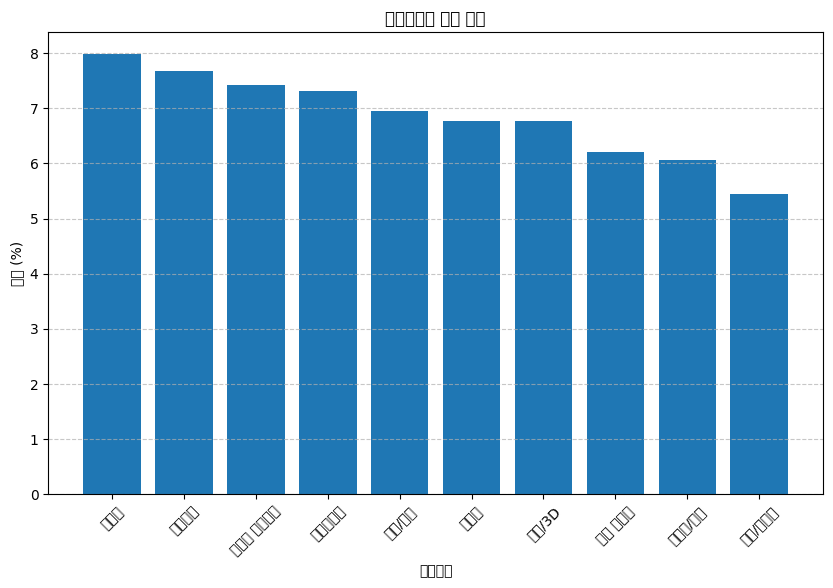

In [75]:
#카테고리 열에서 크리에이티브 값 삭제
non_creative_df = df[df['카테고리'] != '크리에이티브']

# 각 카테고리별로 총 수강 건수 계산
total_counts = non_creative_df.groupby('카테고리')['카테고리'].count()

# 각 카테고리별 환불 건수 계산
refund_counts = non_creative_df[non_creative_df['유형'] == 'REFUND'].groupby('카테고리')['카테고리'].count()

# 비율 계산 & 소수 점 반올림
ratios = round((refund_counts / total_counts) * 100, 2)

# 결과 데이터프레임 생성
result = pd.DataFrame({'환불자수': refund_counts, '총 수강건': total_counts, '비율': ratios})

# '비율' 열을 높은 순서대로 정렬
result = result.sort_values(by='비율', ascending=False)

# 그래프 설정
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar(result.index, result['비율'])

# 그래프 제목 및 축 라벨 설정
plt.title('카테고리별 환불 비율')
plt.xlabel('카테고리')
plt.ylabel('비율 (%)')

plt.show()


---
### **Factor: 계절성** (Monthly / Weekly)

> 1~12월동안 매출확인을 통해 매출에서 계절성을 띄는지 파악한다.\
> 요일별 결제건 추이로 요일성 또한 파악.\
> 계절성에 따른 마케팅 계획을 수립할 수 있는지 확인.

#### 10. **1년간 매출&결제 수 추세** (확인필요 실거래금액이 이상하다)

In [76]:
#월별 실거래금 및 판매 건 수 확인하기
mon_df = paid_df[['month','실거래금액']]

# 월별 판매 건수 데이터프레임 만들기
mon_cnt = paid_df[['month']]
mon_cnt = pd.DataFrame(mon_cnt.groupby('month').value_counts())
mon_cnt = mon_cnt.reset_index()

# 월별로 실 거래금 보기
gr_mon_df = mon_df.groupby('month').agg({
    '실거래금액' : 'sum'    
})

gr_mon_df = gr_mon_df.reset_index()

# 두 테이블 합치기
mon_cnt['실거래금액(백 만)'] = (gr_mon_df['실거래금액']/1000000).astype(int)
mon_cnt['실거래금액(억)'] = (gr_mon_df['실거래금액']/100000000).astype(int)

# bar chart
mon_sale = alt.Chart(mon_cnt).mark_bar().encode(x=alt.X('month:N',
                                                        sort=alt.EncodingSortField(field='month')),
                                                y=alt.Y('실거래금액(백 만):Q', 
                                                        stack=None, 
                                                        title='실거래금액', 
                                                        axis=alt.Axis(title='실거래금액(백 만)')),
                                                )

# line chart
mon_count = alt.Chart(mon_cnt).mark_line(color='red').encode(x=alt.X('month:N'),
                                                             y=alt.Y('count:Q', 
                                                                     axis=alt.Axis(title='판매 건 수'))
                                                             )

# combine charts
combined = alt.layer(mon_sale, mon_count).resolve_scale(y='independent')

# Add grid lines
combined = combined.configure_axis(grid=True,
                                   gridColor='lightgray',
                                   gridOpacity=0.5,
                                   gridDash=[2, 2],  # Set the dash pattern for grid lines
                                   gridWidth=0.5  # Set the width of grid lines
                                   ).properties(title='실거래금액(백만) 대비 판매건수')
combined

alt.LayerChart(...)

### 11. 카테고리별 연간 매출 추세

In [77]:
# 프로그래밍의 월별 실거래금액
df_programming = df_paid[df_paid['카테고리'] == '프로그래밍'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_programming=df_programming.reset_index()
df_programming.drop('index', axis=1, inplace=True)
# 데이터 사이언스의 월별 거래금액
df_Data = df_paid[df_paid['카테고리'] == '데이터 사이언스'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_Data=df_Data.reset_index()
df_Data.drop('index', axis=1, inplace=True)
# 일러스트의 월별 거래금액
df_illu = df_paid[df_paid['카테고리'] == '일러스트'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_illu=df_illu.reset_index()
df_illu.drop('index', axis=1, inplace=True)
# 영상/3D의 월별 거래금액
df_3D= df_paid[df_paid['카테고리'] == '영상/3D'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_3D=df_3D.reset_index()
df_3D.drop('index', axis=1, inplace=True)
# 업무 생산성의 월별 거래금액
df_BP= df_paid[df_paid['카테고리'] == '업무 생산성'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_BP=df_BP.reset_index()
df_BP.drop('index', axis=1, inplace=True)
# 마케팅의 월별 거래금액
df_marketing= df_paid[df_paid['카테고리'] == '마케팅'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_marketing=df_marketing.reset_index()
df_marketing.drop('index', axis=1, inplace=True)
# 부동산/금융의 월별 거래금액
df_property= df_paid[df_paid['카테고리'] == '부동산/금융'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_property=df_property.reset_index()
df_property.drop('index', axis=1, inplace=True)
# 디자인의 월별 거래금액
df_design= df_paid[df_paid['카테고리'] == '디자인'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_design=df_design.reset_index()
df_design.drop('index', axis=1, inplace=True)
# 투자/재테크의 월별 거래금액
df_invest= df_paid[df_paid['카테고리'] == '투자/재테크'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_invest=df_invest.reset_index()
df_invest.drop('index', axis=1, inplace=True)
# 부업/창업의 월별 거래금액
df_side= df_paid[df_paid['카테고리'] == '부업/창업'].groupby("month")["실거래금액"].sum().to_frame().reset_index()
df_side=df_side.reset_index()
df_side.drop('index', axis=1, inplace=True)

In [89]:
## 카테고리별 월별 매출 추세선 그리기
fig = go.Figure()

title = '카테고리의 월별 매출액'
fig.add_trace(go.Scatter(x=df_programming["month"], 
                         y=df_programming["실거래금액"], 
                         name='프로그래밍',
                         line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=df_Data["month"], 
                         y=df_Data["실거래금액"], 
                         name='데이터 사이언스',
                         line=dict(color='#FFC300', width=2)))
fig.add_trace(go.Scatter(x=df_illu["month"], 
                         y=df_illu["실거래금액"], 
                         name='일러스트',
                         line=dict(color='#4ABDAC', width=2)))
fig.add_trace(go.Scatter(x=df_3D["month"], 
                         y=df_3D["실거래금액"], 
                         name='영상/3D',
                         line=dict(color='#2C3E50', width=2)))
fig.add_trace(go.Scatter(x=df_BP["month"], 
                         y=df_BP["실거래금액"], 
                         name='업무 생산성',
                         line=dict(color='#A569BD', width=2)))
fig.add_trace(go.Scatter(x=df_marketing["month"], 
                         y=df_marketing["실거래금액"], 
                         name='마케팅',
                         line=dict(color='#7D3C98', width=2)))
fig.add_trace(go.Scatter(x=df_property["month"], 
                         y=df_property["실거래금액"], 
                         name='부동산/금융',
                         line=dict(color='#A6ACAF', width=2)))
fig.add_trace(go.Scatter(x=df_design["month"], 
                         y=df_design["실거래금액"], 
                         name='디자인',
                         line=dict(color='#F39C12', width=2)))
fig.add_trace(go.Scatter(x=df_invest["month"], 
                         y=df_invest["실거래금액"], 
                         name='투자/재테크',
                         line=dict(color='#2ECC71', width=2)))
fig.add_trace(go.Scatter(x=df_side["month"], 
                         y=df_side["실거래금액"], 
                         name='부업/창업',
                         line=dict(color='#27AE60', width=2)))

fig.update_layout(width=800, height=600, title = '카테고리의 월별 매출액')
fig.show()

### 12. 카테고리별 연간 환불 추세

In [79]:
# 카테고리별 연간 환불 추세선 그래프 그리기
# 프로그래밍의 월별 환불율 계산
df_programming["판매건수"] = df_paid[df_paid['카테고리'] == '프로그래밍'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_programming["환불건수"] = df_refunded[df_refunded['카테고리'] == '프로그래밍'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_programming["환불률"] = df_programming["환불건수"]/df_programming["판매건수"]*100
# 데이터 사이언스의 월별 환불율 계산
df_Data["판매건수"] = df_paid[df_paid['카테고리'] == '데이터 사이언스'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_Data["환불건수"] = df_refunded[df_refunded['카테고리'] == '데이터 사이언스'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_Data["환불률"] = df_Data["환불건수"]/df_Data["판매건수"]*100
# 일러스트의 월별 환불율 계산
df_illu["판매건수"] = df_paid[df_paid['카테고리'] == '일러스트'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_illu["환불건수"] = df_refunded[df_refunded['카테고리'] == '일러스트'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_illu["환불률"] = df_illu["환불건수"]/df_illu["판매건수"]*100
# 영상/3D의 월별 환불율 계산
df_3D["판매건수"] = df_paid[df_paid['카테고리'] == '영상/3D'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_3D["환불건수"] = df_refunded[df_refunded['카테고리'] == '영상/3D'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_3D["환불률"] = df_3D["환불건수"]/df_3D["판매건수"]*100
# 업무 생산성의 월별 환불율 계산
df_BP["판매건수"] = df_paid[df_paid['카테고리'] == '업무 생산성'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_BP["환불건수"] = df_refunded[df_refunded['카테고리'] == '업무 생산성'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_BP["환불률"] = df_BP["환불건수"]/df_BP["판매건수"]*100
# 마케팅의 월별 환불율 계산
df_marketing["판매건수"] = df_paid[df_paid['카테고리'] == '마케팅'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_marketing["환불건수"] = df_refunded[df_refunded['카테고리'] == '마케팅'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_marketing["환불률"] = df_marketing["환불건수"]/df_marketing["판매건수"]*100
# 부동산/금융의 월별 환불율 계산
df_property["판매건수"] = df_paid[df_paid['카테고리'] == '부동산/금융'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_property["환불건수"] = df_refunded[df_refunded['카테고리'] == '부동산/금융'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_property["환불률"] = df_property["환불건수"]/df_property["판매건수"]*100
# 디자인의 월별 환불율 계산
df_design["판매건수"] = df_paid[df_paid['카테고리'] == '디자인'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_design["환불건수"] = df_refunded[df_refunded['카테고리'] == '디자인'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_design["환불률"] = df_design["환불건수"]/df_design["판매건수"]*100
# 투자/재테크의 월별 환불율 계산
df_invest["판매건수"] = df_paid[df_paid['카테고리'] == '투자/재테크'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_invest["환불건수"] = df_refunded[df_refunded['카테고리'] == '투자/재테크'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_invest["환불률"] = df_invest["환불건수"]/df_invest["판매건수"]*100
# 부업/창업의 월별 환불율 계산
df_side["판매건수"] = df_paid[df_paid['카테고리'] == '부업/창업'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_side["환불건수"] = df_refunded[df_refunded['카테고리'] == '부업/창업'].groupby("month")["실거래금액"].count().to_frame().reset_index()["실거래금액"]
df_side["환불률"] = df_side["환불건수"]/df_side["판매건수"]*100

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_programming["month"], 
                         y=df_programming["환불률"], 
                         name='프로그래밍',
                         line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=df_Data["month"], 
                         y=df_Data["환불률"], 
                         name='데이터 사이언스',
                         line=dict(color='#FFC300', width=2)))
fig.add_trace(go.Scatter(x=df_illu["month"], 
                         y=df_illu["환불률"], 
                         name='일러스트',
                         line=dict(color='#4ABDAC', width=2)))
fig.add_trace(go.Scatter(x=df_3D["month"], 
                         y=df_3D["환불률"], 
                         name='영상/3D',
                         line=dict(color='#2C3E50', width=2)))
fig.add_trace(go.Scatter(x=df_BP["month"], 
                         y=df_BP["환불률"], 
                         name='업무 생산성',
                         line=dict(color='#A569BD', width=2)))
fig.add_trace(go.Scatter(x=df_marketing["month"], 
                         y=df_marketing["환불률"], 
                         name='마케팅',
                         line=dict(color='#7D3C98', width=2)))
fig.add_trace(go.Scatter(x=df_property["month"], 
                         y=df_property["환불률"], 
                         name='부동산/금융',
                         line=dict(color='#A6ACAF', width=2)))
fig.add_trace(go.Scatter(x=df_design["month"], 
                         y=df_design["환불률"], 
                         name='디자인',
                         line=dict(color='#F39C12', width=2)))
fig.add_trace(go.Scatter(x=df_invest["month"], 
                         y=df_invest["환불률"], 
                         name='투자/재테크',
                         line=dict(color='#FFC0CB', width=2)))
fig.add_trace(go.Scatter(x=df_side["month"], 
                         y=df_side["환불률"], 
                         name='부업/창업',
                         line=dict(color='#27AE60', width=2)))

fig.update_layout(width=800, height=600, title='카테고리의 월별 환불률')

fig.show()

### 13. 평균요일별 시간대 결제량

In [81]:
# payment 고객만 걸러내는 dataset 만들기
paid_df = df[df['유형']=='PAYMENT']
date_df = paid_df[['hours','요일']]
date_df = pd.DataFrame(date_df.groupby(['요일','hours']).value_counts())
date_index = date_df.reset_index()

# 데이터프레임을 '요일' 컬럼을 기준으로 정렬하기 위한 전처리
d_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_index['요일'] = pd.Categorical(date_index['요일'], categories=d_order, ordered=True)

# 데이터프레임을 '요일' 컬럼을 기준으로 정렬
date_sorted = date_index.sort_values('요일')

# 요일 type을 str로 바꾸기
date_sorted['요일'] = date_sorted['요일'].astype(str)


# 요일별 결제시간 꺾은선 그래프 그리기
alt.Chart(date_sorted).mark_line(interpolate="monotone").encode(x="hours:Q",
                                                                y="count:Q",
                                                                color=alt.Color('요일:N', 
                                                                                sort=d_order, 
                                                                                legend=alt.Legend(title='요일'))
                                                                ).properties(title='요일별 결제 시간')

alt.Chart(...)

In [82]:
# 요일별 환불시간 꺾은선 그래프 그리기
# 데이터프레임 만들기
refund_df = df[df['유형'] == 'REFUND'][['요일', 'hours']]
gr_refund = pd.DataFrame(refund_df.groupby(['요일','hours']).value_counts())
gr_refund = gr_refund.reset_index()

# 데이터프레임을 '요일' 컬럼을 기준으로 정렬하기 위한 전처리
d_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gr_refund['요일'] = pd.Categorical(gr_refund['요일'], categories=d_order, ordered=True)
# # 데이터프레임을 '요일' 컬럼을 기준으로 정렬
refund_index = gr_refund.sort_values('요일')


# 요일별 환불시간 꺾은선 그래프 그리기
alt.Chart(refund_index).mark_line(interpolate="monotone").encode(x="hours:Q",
                                                                 y="count:Q",
                                                                 color=alt.Color('요일:N', 
                                                                                 sort=d_order, 
                                                                                 legend=alt.Legend(title='요일'))
                                                                ).properties(title='요일별 환불 시간')

alt.Chart(...)

# 

## End.